In [1]:
import os 

from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt 

In [2]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\Pluto"

In [43]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [81]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

bias_frames = hdu_lst[np.where(obj_lst=='bias_')]
dark_frames = hdu_lst[np.where(obj_lst=='dark_')]
flat_frames = hdu_lst[np.where(obj_lst=='flat_')]
twiflat_R_frames = hdu_lst[np.where(obj_lst=='twiflat_R_')]
pluto_frames =hdu_lst[np.where(obj_lst=='pluto')]


In [82]:
frame_shape = np.zeros(bias_frames[0].data.shape)

# Median Bias Frames
bias_frame = np.median(np.stack([b.data for b in bias_frames]),axis=0)

# Median Dark Frames 
dark_frame = np.median(np.stack([b.data for b in dark_frames]),axis=0)
dark_exptime = dark_frames[0].header['EXPTIME']

# Median Bright Flats
bright_flat_frame = np.median(np.stack([b.data for b in flat_frames]),axis=0)
bf_exptime = flat_frames[0].header['EXPTIME']
bright_flat_frame /= bf_exptime

# Median Dark Flats 
dark_flat_frame = np.median(np.stack([b.data for b in twiflat_R_frames]),axis=0)
df_exptime = twiflat_R_frames[0].header['EXPTIME']
dark_flat_frame /= df_exptime

print()

dark_image = (dark_frame - bias_frame) / dark_exptime
flat_image = bright_flat_frame - dark_flat_frame

In [96]:
sci_frame = pluto_frames[0].data 
pluto_exptime = pluto_frames[0].header['EXPTIME']
sci_frame = np.divide(sci_frame, float(pluto_exptime))

C:\Users\avipa\AppData\Local\Temp\ipykernel_21340\3115354036.py:1: RuntimeWarning: divide by zero encountered in divide
  res = sci_frame - dark_image / flat_image


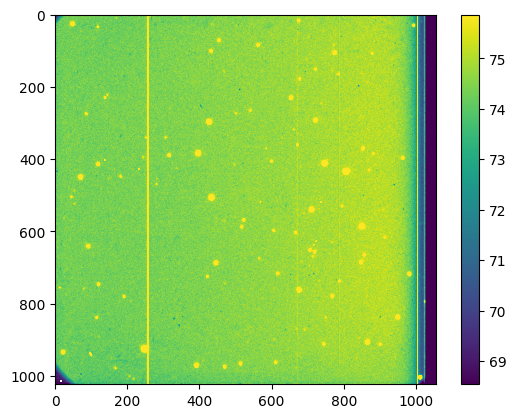

In [98]:
res = sci_frame - dark_image / flat_image
plt.imshow(res, vmin=np.percentile(res, 2), vmax=np.percentile(res,97))
plt.colorbar()